# Autoencoder on global data

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, AveragePooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Lambda, Reshape
from keras.models import Model, load_model
from keras import optimizers
from keras import regularizers

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from sklearn.model_selection import train_test_split

import gc #garbace collector
import multiprocessing as mp

import os

%load_ext tensorboard
import datetime

/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sebastian/anaconda3/envs/py37/lib/pyt

# 1. Custom functions

#### Reflection Padding class

In [2]:
from keras.engine.topology import Layer
from keras.engine import InputSpec

import math
from keras import backend as K

In [3]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [4]:
def set_trainable(model, trainable):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

#### Charbonnier loss

A General and Adaptive Robust Loss Function - Jonathan T. Barron, Google Research <br>
https://arxiv.org/pdf/1701.03077.pdf

In [5]:
def charbonnier(y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred) + 1e-10))

def charbonnier_sum(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_true - y_pred) + 1e-10), axis=-1)

#### KL loss

In [6]:
def KL_loss():
    loss  = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    loss  = K.sum(loss, axis=-1)
    loss *= -0.5
    
    return loss

#### mean gaussian NLL

In [7]:
def mean_gaussian_negative_log_likelihood(y_true, y_pred):
    nll = 0.5 * np.log(2 * np.pi) + 0.5 * K.square(y_pred - y_true)
    axis = tuple(range(1, len(K.int_shape(y_true))))
    
    return K.mean(K.sum(nll, axis=axis), axis=-1)

#### VAE loss

In [8]:
from keras.callbacks import Callback

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end(self, epoch, logs={}):
        new_weight = K.get_value(self.weight)
         
        if new_weight!=1: 
            if epoch+1 >= KL_start:
                print("KL_weight: " + str(new_weight))
                new_weight = sigmoid(-10 + KL_growth*(epoch+1-KL_start))
            
        if new_weight > 1 - 1e-6:
            new_weight = 1
            
        K.set_value(self.weight, new_weight)

In [11]:
def VAE_loss(y_true, y_pred):
    global weight
    
    rc_loss = charbonnier_sum(y_true, y_pred)
    #rc_loss = charbonnier(y_true, y_pred)
    #rc_loss = K.sum(K.square(y_true - y_pred), axis=-1)
    
    KL_loss  = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    KL_loss  = K.sum(KL_loss, axis=-1)
    KL_loss *= -0.5

    return K.mean(rc_loss + weight*KL_loss)

In [12]:
def perceptual_loss(y_true, y_pred):
    y_true = keras.layers.Concatenate()([y_true, y_true, y_true])
    y_pred = keras.layers.Concatenate()([y_pred, y_pred, y_pred])
    
    h1_list = lossModel(y_true)
    h2_list = lossModel(y_pred)
    
    rc_loss = 0.0
    
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        #rc_loss = rc_loss + weight * K.mean(K.sum(K.square(h1 - h2), axis=-1))
        rc_loss = rc_loss + weight * charbonnier_sum(h1, h2)
    return 0.5*rc_loss

In [13]:
def VAE_DFC_loss(y_true, y_pred):
    '''Total loss for the DFC VAE'''
    global weight
    
    return K.mean(perceptual_loss(y_true, y_pred) + weight*KL_loss(), axis=-1)

#### PSNR for image quality measurement

In [14]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 / math.log(10) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true + 1e-10), axis=-1)))

def PSNR_np(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 / np.log(10) * np.log((max_pixel ** 2) / (np.mean((y_pred - y_true + 1e-10)**2)))

#### Reparametrization trick

In [15]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    learning_rate = 5e-5
    
    if epoch%2 == 0:
        learning_rate = learning_rate / (1.0005*(epoch+1))

    #tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

# 2. Loading the data

nc = Dataset('GEBCO_2019.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0) #otherwise the 'map' is upside down and mirrored

Cropped = None

#### To use only Hawaii:


nc = Dataset('tohoku_gebco_ucsb3_2000m_hawaii_bath.nc', 'r')
Cropped = True

dim1 = int(np.array(nc.variables['x']).shape[0])
dim2 = int(np.array(nc.variables['y']).shape[0])
Z = np.flip(np.array(nc.variables['z']), axis=0)


#### Other small subset

In [17]:
nc = Dataset('GEBCO_2019_cropped.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0)

Cropped = True

In [18]:
dim1, dim2, Z.shape

(15000, 20000, (20000, 15000))

# 3. Pre-processing

#### 'Remove' altitudes > 0 by setting their values to be 0.

In [19]:
#Z[Z>0] = 0

#### Offset values to be non-negative

In [20]:
Z_min = np.min(Z)
Z = Z + np.abs(Z_min)

#### Rescaling to [0, 1]

In [21]:
Z_max = np.max(Z)
Z_max

Z = Z / Z_max

#### Plot the map

In [22]:
#plt.matshow(Z)

#### Create 3-dimensional array containing num_images small pictures.

In [23]:
x, y = 96, 96

num_images = int(dim1*dim2 / (x*y))
num_images

32552

In [24]:
ratio_x = dim1/x
ratio_y = dim2/y

ratio_x, ratio_y

(156.25, 208.33333333333334)

In [25]:
cutoff_x = math.ceil(x * (ratio_x-int(ratio_x)))
cutoff_y = math.ceil(y * (ratio_y-int(ratio_y)))
    
cutoff_x, cutoff_y

(24, 33)

In [26]:
data = np.zeros([num_images, y, x])
i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        data[i, :, :] = Z[r:r+y, c:c+x]
        i = i + 1

In [27]:
if Cropped==True:
    for i in range(data.shape[0]):
        data[i,:,:] = data[i,:,:].T

#### Split into train and test set

In [28]:
#def split_1(queue, data):
#    result = train_test_split(data, test_size=0.01)
#    queue.put(result)

In [29]:
#queue = mp.Queue()
#p = mp.Process(target=split_1, args=(queue, data_augmented))
#p.start()
#p.join()

#results = queue.get()

#p.close()



In [30]:
#gc.collect()

In [31]:
test_size = 0.05
X_training, X_test = train_test_split(data, test_size=test_size, random_state=7)

## Data Augmentation

Add 90-degree rotations as augmented data

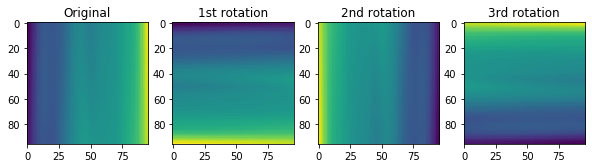

In [32]:
plt.figure(figsize=(10, 4))

plt.subplot(1,4,1)
plt.imshow(X_training[33, ...])
plt.title("Original")

plt.subplot(1,4,2)
plt.imshow(X_training[33, ...].T)
plt.title("1st rotation")

plt.subplot(1,4,3)
plt.imshow(np.flip(X_training[33, ...]))
plt.title("2nd rotation")

plt.subplot(1,4,4)
plt.imshow(np.flip(X_training[33, ...].T))
plt.title("3rd rotation")

plt.show()

In [33]:
index = int(num_images*(1-test_size))
if Cropped == True:
    X_train = np.zeros([index*4, y, x])
else:
    X_train = np.zeros([index*2, y, x])
    
X_train[0:index, :, :] = X_training

In [34]:
for j in range(index):
    X_train[index*1 + j, :, :] = X_training[j, :, :].T
    if Cropped == True:
        X_train[index*2 + j, :, :] = np.flip(X_training[j, :, :])
        X_train[index*3 + j, :, :] = np.flip(X_training[j, :, :].T)

In [35]:
X_training.shape, X_train.shape

((30924, 96, 96), (123696, 96, 96))

#### Reshaping for Keras

In [36]:
X_train = X_train.reshape(-1, y, x, 1)


In [37]:
X_test = X_test.reshape(-1, y, x, 1)

In [38]:
X_train.shape, X_test.shape

((123696, 96, 96, 1), (1628, 96, 96, 1))

#### Free up some memory

In [39]:
del X_training

In [40]:
gc.collect()

8444

#### Create validation set

In [41]:
X_train, X_val = train_test_split(X_train, test_size=0.05, random_state=7)

In [42]:
gc.collect()

50

# 4. Convolutional Autoencoder

### 4.1 Network parameters

In [43]:
epochs      = 100
batch_size  = 128
kernel_down = 4
kernel_up   = 3
filters_enc = [64, 128, 128, 256]
filters_dec = filters_enc.copy()
filters_dec.reverse()

pre_latent  = 100
latent_dim  = 100

KL_start = 3
KL_growth = 1.3

recon_vs_gan_weight = 1e-6

### 4.2 Define Variational Autoencoder

In [44]:
#encoder model
inputs  = Input(shape = (y, x, 1), name='encoder_inputs')

a = inputs
filters = filters_enc

for i in range(3):
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i], kernel_initializer='he_uniform', 
               kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
               strides=2, padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)

a = ReflectionPadding2D(padding=(1,1))(a)
a = Conv2D(filters[i+1], kernel_initializer='he_uniform', 
           kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
           strides=2, padding='valid')(a)
a = BatchNormalization(axis=3)(a)
a = keras.layers.LeakyReLU(name='encoded')(a)

#shape retrieval for decoder part
shape = K.int_shape(a)

#a = keras.layers.GlobalAveragePooling2D()(a)

# generate latent vector Q(z|X)
a = Flatten()(a)
a = Dense(pre_latent, kernel_initializer='he_uniform')(a)#, activation='relu')(a)
a = BatchNormalization()(a)
a = keras.layers.LeakyReLU()(a)

z_mean = Dense(latent_dim, name='z_mean')(a)
z_log_var = Dense(latent_dim, name='z_log_var')(a)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [45]:
#encoder.summary()

In [46]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
a = Dense(pre_latent, activation='relu', kernel_initializer='he_uniform')(latent_inputs)
a = Dense(shape[1] * shape[2] * shape[3], kernel_initializer='he_uniform')(a)#, activation='relu')(a)
a = BatchNormalization()(a)
a = keras.layers.LeakyReLU()(a)

a = Reshape((shape[1], shape[2], shape[3]))(a)

filters = filters_dec
for i in range(3):

    a = UpSampling2D((2,2))(a)
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i+1], kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
               strides=1, kernel_initializer='he_uniform', padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)
    
#a = ReflectionPadding2D(padding=(1,1))(a)
#a = Conv2D(32, kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
#           strides=1, kernel_initializer='he_uniform', padding='valid')(a)
#a = BatchNormalization(axis=3)(a)
#a = keras.layers.LeakyReLU()(a)    

a = UpSampling2D((2,2))(a)
a = ReflectionPadding2D(padding=(1,1))(a)
out = Conv2D(filters=1, kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
             kernel_initializer='he_normal', activation='tanh',
             padding='valid', name='decoder_output')(a)

# instantiate decoder model
decoder = Model(latent_inputs, out, name='decoder')

In [47]:
#decoder.summary()

In [48]:
outputs = decoder(encoder(inputs)[2])
VAE = Model(inputs, outputs, name='VAE')
VAE_dummy = Model(inputs, outputs)
VAE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 96, 96, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 1863708   
_________________________________________________________________
decoder (Model)              (None, 96, 96, 1)         1496053   
Total params: 3,359,761
Trainable params: 3,339,337
Non-trainable params: 20,424
_________________________________________________________________


In [49]:
#discriminator
a = inputs
filters = filters_enc

for i in range(3):
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i], kernel_initializer='he_uniform', 
               kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
               strides=2, padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)

a = ReflectionPadding2D(padding=(1,1))(a)
a = Conv2D(filters[i+1], kernel_initializer='he_uniform', 
           kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
           strides=2, padding='valid')(a)


a = BatchNormalization(axis=3)(a)
a = keras.layers.LeakyReLU()(a)
a = Flatten()(a)
a = Dense(512, kernel_initializer='he_uniform')(a)
a = BatchNormalization()(a)
a = keras.layers.LeakyReLU()(a)
out = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(a)


# instantiate discriminator model
discriminator = Model(inputs, [out, a], name='discriminator')

In [50]:
#discriminator.summary()

### training set up

In [51]:
E_mean, E_logsigma, Z_sample = encoder(inputs)
#z_p = E_mean + E_logsigma
latent_shape = K.int_shape(latent_inputs)[1:]
z_p = Input(shape=(latent_shape))

x_tilde = decoder(Z_sample)
x_p     = decoder(z_p)

In [52]:
dis_x_tilde, dis_feat_tilde = discriminator(x_tilde)
dis_x_p   = discriminator(x_p)[0]
dis_x, dis_feat = discriminator(inputs)

In [53]:
dis_nll_loss = mean_gaussian_negative_log_likelihood(dis_feat, dis_feat_tilde)

kl_loss = K.mean(-0.5 * K.sum(1 + E_logsigma - K.square(E_mean) - K.exp(E_logsigma), axis=-1))

### create models for training

In [54]:
def VAE_loss2(y_true, y_pred):
    global weight
    
    rc_loss = charbonnier_sum(y_true, y_pred)
    #rc_loss = charbonnier(y_true, y_pred)
    #rc_loss = K.sum(K.square(y_true - y_pred), axis=-1)
    
    KL_loss  = 1 + E_logsigma - K.square(E_mean) - K.exp(E_logsigma)
    KL_loss  = K.sum(KL_loss, axis=-1)
    KL_loss *= -0.5

    return K.mean(rc_loss + weight*KL_loss)

In [55]:
encoder_train = Model(inputs, dis_feat_tilde, name='enc')
#encoder_train.add_loss(kl_loss)
#encoder_train.add_loss(dis_nll_loss) #charbonnier(_sum) instead?
#encoder_train.add_loss(charbonnier(dis_feat, dis_feat_tilde))
weight = K.variable(0.0)
encoder_train.add_loss(VAE_loss2(dis_feat, dis_feat_tilde))

In [56]:
decoder_train = Model([inputs, z_p], [dis_x_tilde, dis_x_p], name='dec')
normalized_weight = recon_vs_gan_weight / (1. - recon_vs_gan_weight)
#decoder_train.add_loss(normalized_weight * dis_nll_loss)
decoder_train.add_loss(K.mean(charbonnier_sum(dis_feat, dis_feat_tilde)))

In [57]:
discriminator_train = Model([inputs, z_p], [dis_x, dis_x_tilde, dis_x_p], name='dis')

### Additional models for testing

In [58]:
vae = Model(inputs, x_tilde, name='vae')
vaegan = Model(inputs, dis_x_tilde, name='vaegan')

### 4.3 Fit Autoencoder

### Callbacks

In [59]:
!mkdir model_weights/$(date +%Y%m%d)

In [60]:
date = datetime.datetime.now().strftime('%Y%m%d')
filepath='model_weights/' + date + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
save_weights_callback = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                                                  save_weights_only=True)

### Fit

In [61]:
#weight = K.variable(0.0)
#VAE.add_loss(VAE_loss(K.flatten(inputs), K.flatten(outputs)))
#VAE.add_loss(VAE_DFC_loss(inputs, outputs))

In [62]:
optim = optimizers.Adam(lr=1e-4)

In [63]:
set_trainable(encoder, False)
set_trainable(decoder, False)
discriminator_train.compile(optim, ['binary_crossentropy'] * 3, ['acc'] * 3)
discriminator_train.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 100), (None, 1863708     encoder_inputs[0][0]             
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
decoder (Model)                 (None, 96, 96, 1)    1496053     encoder[2][2]                    
              

In [64]:
set_trainable(discriminator, False)
set_trainable(decoder, True)
decoder_train.compile(optim, ['binary_crossentropy'] * 2, ['acc'] * 2)
decoder_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 100), (None, 1863708     encoder_inputs[0][0]             
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
decoder (Model)                 (None, 96, 96, 1)    1496053     encoder[2][2]                    
                                                                 input_1[0][0]                    
__________

In [65]:
set_trainable(decoder, False)
set_trainable(encoder, True)
encoder_train.compile(optim)
encoder_train.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 96, 96, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 1863708   
_________________________________________________________________
decoder (Model)              (None, 96, 96, 1)         1496053   
_________________________________________________________________
discriminator (Model)        [(None, 1), (None, 512)]  5643073   
Total params: 9,002,834
Trainable params: 1,862,356
Non-trainable params: 7,140,478
_________________________________________________________________


In [66]:
set_trainable(vae, True)
vae.add_loss(VAE_loss2(dis_feat, dis_feat_tilde))
vae.compile(optim)
set_trainable(vaegan, True)

In [67]:
#encoder.compile(optimizer = optimizers.Adam(lr=1e-6, clipnorm=1), loss=charbonnier_sum)
#decoder.compile(optimizer = optimizers.Adam(lr=1e-6, clipnorm=1), loss=charbonnier_sum)
#discriminator.compile(optimizer = optimizers.Adam(lr=1e-6, clipnorm=1), loss=charbonnier_sum)
#VAE.compile(optimizer = optimizers.Adam(lr=1e-6, clipnorm=1))
#VAE.compile(optimizer = optimizers.Adam(decay=1e-4, clipnorm=1))

#workaround for PSNR
#VAE_dummy.compile(optimizer=optimizers.Adam(), loss=[charbonnier], metrics=[PSNR])

In [68]:
#encoder_train.load_weights('model_weights/20200220/enc_end.hdf5')
#decoder_train.load_weights('model_weights/20200220/dec_end.hdf5')
#discriminator_train.load_weights('model_weights/20200220/dis_end.hdf5')
#vae.load_weights('VAE_DFC_cropped_200e.hdf5')

In [69]:
#filepath_temp='model_weights/' + date + '/enc_weights.{epoch:02d}-{loss:.2f}.hdf5'
#save_enc_callback = keras.callbacks.ModelCheckpoint(filepath_temp, monitor='loss',
#                                                    save_best_only=True, save_weights_only=True)
#filepath_temp='model_weights/' + date + '/dec_weights.{epoch:02d}-{loss:.2f}.hdf5'
#save_dec_callback = keras.callbacks.ModelCheckpoint(filepath_temp, monitor='loss',
#                                                    save_best_only=True, save_weights_only=True)
#filepath_temp='model_weights/' + date + '/dis_weights.{epoch:02d}-{loss:.2f}.hdf5'
#save_dis_callback = keras.callbacks.ModelCheckpoint(filepath_temp, monitor='loss',
#                                                    save_best_only=True, save_weights_only=True)
#filepath_temp='model_weights/' + date + '/vae_weights.{epoch:02d}-{loss:.2f}.hdf5'
#save_vae_callback = keras.callbacks.ModelCheckpoint(filepath_temp, monitor='loss',
#                                                    save_best_only=True, save_weights_only=True)

In [70]:
#vaegan.load_weights('model_weights/20200223/vaegan_weights.hdf5')

In [71]:
#y_true  = np.ones((X_train.shape[0], 1))
#y_fake  = np.zeros((X_train.shape[0], 1))
y_true  = np.ones((batch_size, 1))
y_fake  = np.zeros((batch_size, 1))

In [141]:
encoder_train.history = keras.callbacks.History()
decoder_train.history = keras.callbacks.History()
discriminator_train.history = keras.callbacks.History()

metrics = [{'di_l': 1, 'di_l_t': 2, 'di_l_p': 3, 'di_a': 4, 'di_a_t': 7, 'di_a_p': 10}, {'de_l_t': 1, 'de_l_p': 2, 'de_a_t': 3, 'de_a_p': 5}, {'en_l': 0}]

callback_metrics = [n for m in metrics for n in m.keys()]

progress_bar = keras.callbacks.ProgbarLogger(count_mode='steps', stateful_metrics=['acc'])
base_logger = keras.callbacks.BaseLogger(stateful_metrics=['acc'])
callbacks = keras.callbacks.CallbackList([progress_bar, AnnealingCallback(weight), base_logger,
                                          encoder_train.history, decoder_train.history, 
                                          discriminator_train.history])

In [161]:
epoch_start = 550
epochs = 750
batches_per_epoch = X_train.shape[0] // batch_size

if epoch_start > KL_start:
    weight = K.variable(sigmoid(-10 + KL_growth*(epoch_start+1-KL_start)))

In [143]:
metrics[0].items()

dict_items([('di_l', 1), ('di_l_t', 2), ('di_l_p', 3), ('di_a', 4), ('di_a_t', 7), ('di_a_p', 10)])

In [133]:
callbacks.set_model(vaegan)
callbacks.set_params({
    'epochs': epochs,
    'steps': batches_per_epoch,
    'verbose': 1,
    'do_validation': False,
    'metrics': callback_metrics,
})

callbacks.on_train_begin()

epoch_logs = {}
#for epoch in range(epochs):
for epoch in range(epoch_start, epochs):

    callbacks.on_epoch_begin(epoch)

    batch_indexes = np.random.permutation(X_train.shape[0])

    for batch in range(batches_per_epoch):
        
        # build batch logs
        batch_logs = {}
        batch_logs['batch'] = batch
        batch_logs['size'] = batch_size
        callbacks.on_batch_begin(batch, batch_logs)
        
        batch_index = batch_indexes[batch*batch_size:(batch+1)*batch_size]
        noise   = np.random.normal(0, 1, (batch_size, latent_dim))

        DisLoss = discriminator_train.train_on_batch([X_train[batch_index], noise], [y_true, y_fake, y_fake])
        DecLoss = decoder_train.train_on_batch([X_train[batch_index], noise], [y_true, y_true])
        EncLoss = encoder_train.train_on_batch(X_train[batch_index]
                                              )
        #EncLoss = encoder_train.fit(X_train, verbose=0, batch_size=batch_size, epochs=epoch+1, 
        #                            initial_epoch=epoch, callbacks=[AnnealingCallback(weight),
        #                                                            save_enc_callback])

        #VAELoss = vae.train_on_batch(X_train[batch_index], None)
        
        temp = [DisLoss, DecLoss, EncLoss]
        for j in range(3):
            for name, i in metrics[j].items():
                batch_logs[name] = temp[j, i]
         
        
        #batch_logs['DisLoss'] = DisLoss[0]
        #batch_logs['DecLoss'] = DecLoss[0]
        #batch_logs['VAELoss'] = VAELoss
        
        callbacks.on_batch_end(batch, batch_logs)
        
    callbacks.on_epoch_end(epoch, epoch_logs)
    vaegan.save_weights('model_weights/' + date + '/vaegan_weights.hdf5')
    
callbacks.on_train_end()

In [ ]:
vaegan.evaluate()

In [134]:
t = np.reshape(X_test[0], (1, 96, 96 ,1))
t_fake = decoder.predict(np.random.normal(size=(1,100)))

In [135]:
vaegan.predict(t), vaegan.predict(t_fake)

(array([[9.046765e-05]], dtype=float32),
 array([[1.7184207e-06]], dtype=float32))

### 4.4 Plot training & validation losses

In [ ]:
#decoder_train.save_weights('model_weights/' + date + '/dec_end.hdf5')
#encoder_train.save_weights('model_weights/' + date + '/enc_end.hdf5')
#discriminator_train.save_weights('model_weights/' + date + '/dis_end.hdf5')
#vae.save_weights('model_weights/' + date + '/vae_end.hdf5')
#vaegan.save_weights('model_weights/' + date + '/vae_gan_end.hdf5')

In [ ]:
vaegan_train = vaegan.history
loss = vaegan_train.history['loss']
val_loss = vaegan_train.history['val_loss']

plt.figure()
plt.plot(range(epoch_start, epochs), loss, 'bo', label='Training loss')
plt.plot(range(epoch_start, epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### 4.5 Predicted, reconstructed & latent space images

In [ ]:
#VAE.load_weights('VAE_global_10e.hd5')

In [73]:
pred = vae.predict(X_test)

encoded = Model(inputs=inputs, outputs=encoder.get_layer('encoded').output)
encoded_states = np.mean(encoded.predict(X_test), axis=3, keepdims=True)

x_encoded = encoded_states.shape[1]
y_encoded = encoded_states.shape[2]

Test Images (96x96)


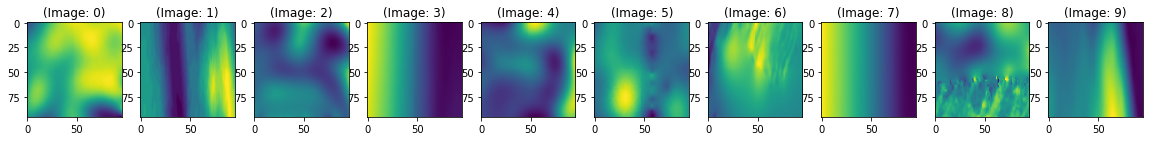

Reconstruction of Test Images (96x96)


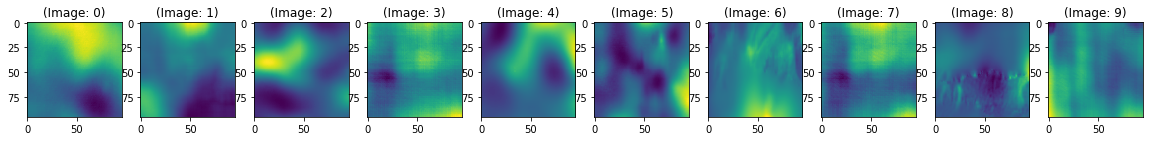

Latent Representation of Test Images (6x6)


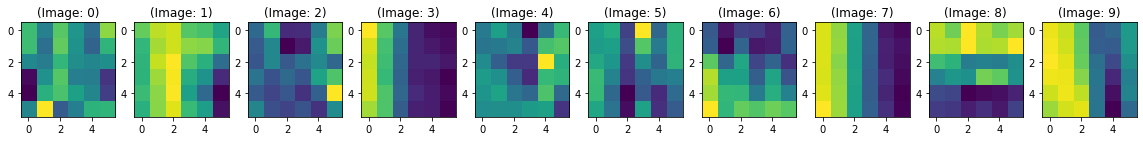

In [75]:
vmin = np.zeros(10)
vmax = np.zeros(10)

plt.figure(figsize=(20, 4))
print("Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    vmin[i] = np.min(X_test[i, ..., 0])
    vmax[i] = np.max(X_test[i, ..., 0])
    plt.imshow(X_test[i, ..., 0], norm=plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], norm=plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Latent Representation of Test Images (" + str(y_encoded) + "x" + str(x_encoded) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(encoded_states[i, ..., 0], norm=plt.Normalize())
    plt.title("(Image: " + str(i) + ")")
plt.show()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

# 5. Reconstruction Errors

#### On Test set

In [76]:
error_test = np.linalg.norm(X_test - pred, axis=(1,2))
PSNR_test = [PSNR_np(X_test[i], pred[i]) for i in range(X_test.shape[0])]
np.linalg.norm(error_test), np.mean(PSNR_test)

(139.49658790391908, 32.09448546148516)

In [77]:
x1 = np.argmax(error_test)
x2 = np.argmin(PSNR_test)
error_test[x1], PSNR_test[x2]

(array([21.36251409]), 13.052377412772106)

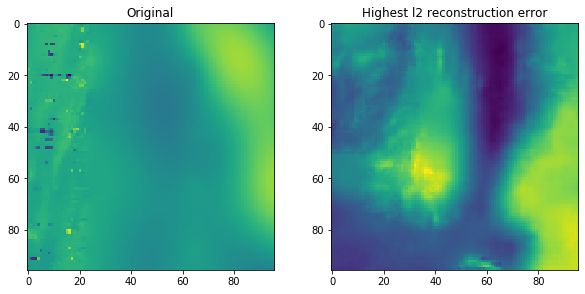

In [79]:
vmin = np.min(X_test[x1, :, :, 0])
vmax = np.max(X_test[x1, :, :, 0])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(X_test[x1, :, :, 0], norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Highest l2 reconstruction error")
plt.imshow(pred[x1, :, :, 0], norm=plt.Normalize(vmin=vmin, vmax=vmax))

#### Total Reconstruction error

In [80]:
data_reconstructed = vae.predict(data.reshape(-1, y, x, 1)).reshape(-1, y, x)

error_total = np.linalg.norm(data - data_reconstructed, axis=(1,2))
PSNR_total  = [PSNR_np(data[i], data_reconstructed[i]) for i in range(data.shape[0])]
np.linalg.norm(error_total), np.mean(PSNR_total)

(625.180811067315, 32.093872020613134)

In [81]:
x3 = np.argmax(error_total)
x4 = np.argmin(PSNR_total)
error_total[x3], PSNR_total[x4]

(31.45721154088699, 9.691020201155844)

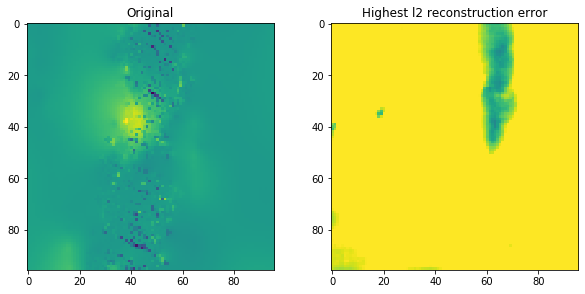

In [82]:
vmin = np.min(data[x3, :, :])
vmax = np.max(data[x3, :, :])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(data[x3, :, :], norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Highest l2 reconstruction error")
plt.imshow(data_reconstructed[x3, :, :], norm=plt.Normalize(vmin=vmin, vmax=vmax))

# 6. Entire map

#### Reshape to match model input shape

In [83]:
data_encoded = data.reshape(-1, y, x, 1)

Values are already [0,1]

#### Encode entire dataset

In [84]:
data_encoded = np.mean(encoded.predict(data_encoded), axis=3, keepdims=True)

In [85]:
data_reconstructed.shape, data_encoded.shape

((32552, 96, 96), (32552, 6, 6, 1))

In [86]:
gc.collect()

93645

#### Retransform to one big matrix

In [87]:
if Cropped==True:
    Z_reconstructed = np.zeros([int(ratio_y)*y, int(ratio_x)*x])

    i=0
    for r in range(0, Z_reconstructed.shape[0], y):
        for c in range(0, Z_reconstructed.shape[1], x):
            Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0].T
            i = i + 1

In [88]:
Z_encoded = np.zeros([int(ratio_y)*y_encoded, int(ratio_x)*x_encoded])

i=0
for r in range(0, Z_encoded.shape[0], y_encoded):
    for c in range(0, Z_encoded.shape[1], x_encoded):
        Z_encoded[r:r+y_encoded, c:c+x_encoded] = data_encoded[i, ..., 0].T
        i = i + 1

#### Plot latent space representation

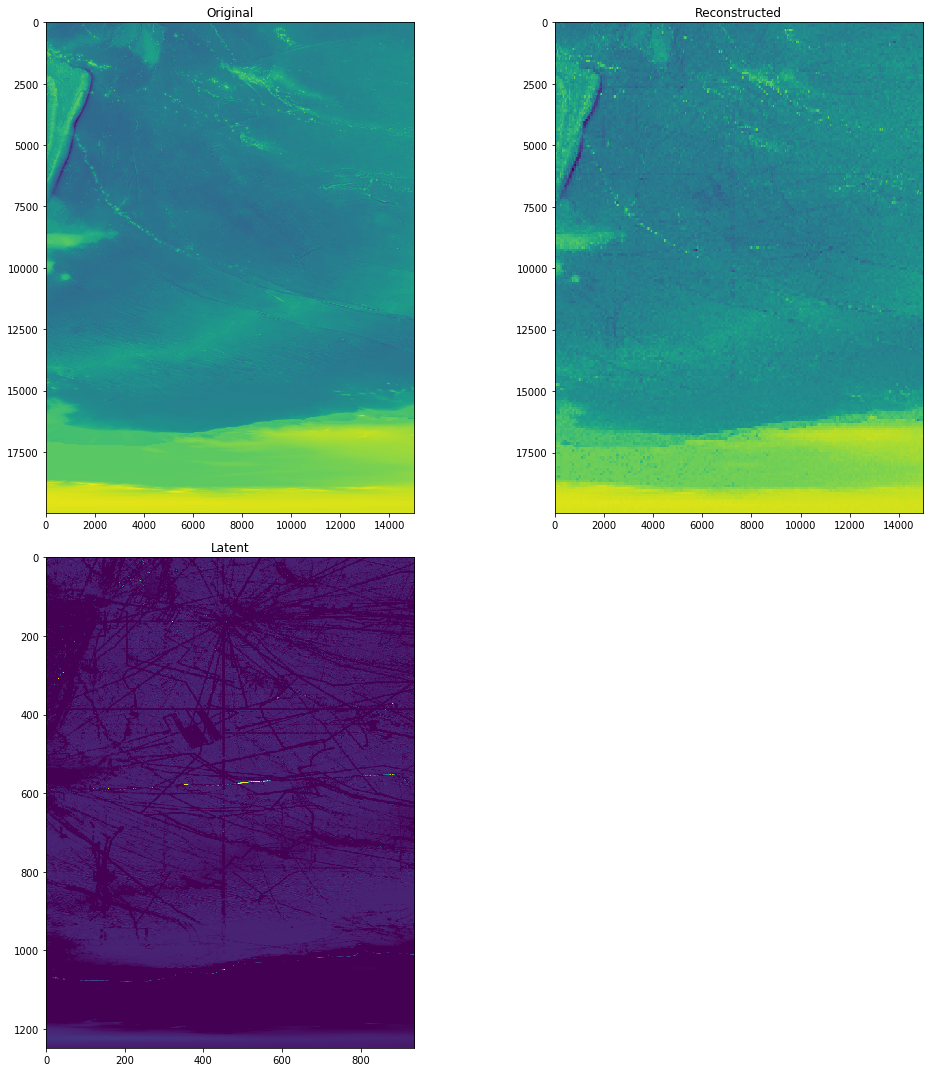

In [137]:
if Cropped==True:
    vmin = np.min(Z)
    vmax = np.max(Z)
    
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.title("Original")
    plt.imshow(Z, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    plt.subplot(2,2,2)
    plt.title("Reconstructed")
    plt.imshow(Z_reconstructed, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    plt.subplot(2,2,3)
    plt.title("Latent")
    plt.imshow(Z_encoded, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    plt.tight_layout()
    #plt.subplots_adjust(hspace=-0.53)
else:
    plt.matshow(Z_encoded)

In [134]:
Z_reconstructed = np.zeros([int(ratio_y)*y, int(ratio_x)*x])
vmin = np.min(Z)
vmax = np.max(Z)

i=0
for r in range(0, Z_reconstructed.shape[0], y):
    for c in range(0, Z_reconstructed.shape[1], x):
        Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0].T
        i = i + 1

In [ ]:
plt.figure(figsize=(200,200))
plt.matshow(Z, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar()

In [ ]:
print('Original space: ' + str(dim2) + 'x' + str(dim1))
print('Reduced space:  ' + str(Z_encoded.shape[0]) + 'x' + str(Z_encoded.shape[1]))
print('--> reduction of ' + str(np.round((1 - Z_encoded.shape[0]*Z_encoded.shape[1]/dim1/dim2)*100, 2)) + '%')

In [ ]:
%%javascript
IPython.notebook.save_notebook()